## Test Adult dataset
- Document of dataset: 
    + https://fairlearn.org/main/user_guide/datasets/acs_income.html#dataset-description
    + https://fairlearn.org/main/api_reference/generated/fairlearn.datasets.fetch_adult.html
    + https://archive.ics.uci.edu/dataset/2/adult


In [2]:
# Custom imports
# import my_helper # my helper functions

# General imports
from IPython.display import Markdown, display, clear_output
from functools import partial
import pathlib
import numpy as np
import pandas as pd
import shap

# DL imports
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split

# Choose the fairness metric
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)

# Some "difference" metrics (as in Nils' paper)
# All ranges are [0,1] -> no need to scale 
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference,
    true_positive_rate_difference,
    false_positive_rate_difference,
)

torch.manual_seed(27)
clear_output()
np.random.seed(27)

## Data Loading

In [3]:
# ---------------------------
# Data Loading and Preparation
# ---------------------------
from aif360.sklearn.datasets import fetch_german

X, y = fetch_german()


# The dataset and target labels have 3 index groups: sex, age, and foreign_worker -> Different from the previous datasets
# Now clear those indices to go back to the same format with previous datasets
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Binarize labels
y = y.map({'good': 1, 'bad': 0})


In [4]:
y = y.to_numpy(dtype=int)

In [5]:
# Add binary_age column based on the condition, value = aged if age >= 25 else young
X['age_group'] = X['age'].apply(lambda x: 'aged' if x >= 25 else 'young')

# X['age_group'] = (X['age'] >= 25)

In [6]:
y_df = pd.DataFrame(y)
print(y_df.value_counts(normalize=True))

0
1    0.7
0    0.3
Name: proportion, dtype: float64


## Data Preprocessing

### Label Encoding

In [17]:
from sklearn.preprocessing import LabelEncoder

# 1. Make a copy and find *all* categorical columns (including "Sex")
X_enc = X.copy()
all_cat_cols = X_enc.select_dtypes(['object', 'category']).columns

# 2. Encode each categorical, storing its mapping
label_mappings = {}
for col in all_cat_cols:
    le = LabelEncoder()
    X_enc[col] = le.fit_transform(X_enc[col])
    label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))


In [18]:
# 3. Now drop the sensitive column
X_enc_drop = X_enc.drop(columns=["sex"])

# 4. Recompute your final cat_cols _after_ dropping
cat_cols = [c for c in all_cat_cols if c != "sex"]

# 5. Compute cardinalities in the same order as cat_cols
cardinalities = [len(label_mappings[c]) for c in cat_cols]

print("Final categorical columns:", cat_cols)
print("Their cardinalities:      ", cardinalities)

# Your numeric columns remain:
num_cols = [c for c in X_enc_drop.columns if c not in cat_cols]

Final categorical columns: ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker', 'marital_status', 'age_group']
Their cardinalities:       [4, 5, 10, 5, 5, 3, 4, 3, 3, 4, 2, 2, 4, 2]


### Split and format

In [19]:
# Train/test split
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X_enc_drop, y, X_enc['sex'], test_size=0.1, random_state=7
)

In [20]:
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)

# Convert all data to integers -> avoid errors in training
y_train_np = y_train.astype(np.int64).values if isinstance(y_train, pd.Series) else y_train.astype(np.int64)
y_test_np = y_test.astype(np.int64).values if isinstance(y_test, pd.Series) else y_test.astype(np.int64)

# Convert data to tensors
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np)
X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np) #.type(torch.LongTensor) 

# Convert to numpy / tensors
X_train_num = X_train[num_cols].to_numpy(dtype=np.float32)
X_test_num  = X_test[num_cols].to_numpy(dtype=np.float32)

X_train_cat = X_train[cat_cols].to_numpy(dtype=np.int64)
X_test_cat  = X_test[cat_cols].to_numpy(dtype=np.int64)

y_train_np = y_train.astype(np.int64).values if isinstance(y_train, pd.Series) else y_train.astype(np.int64)
y_test_np = y_test.astype(np.int64).values if isinstance(y_test, pd.Series) else y_test.astype(np.int64)

X_train_num_t = torch.from_numpy(X_train_num)
X_train_cat_t = torch.from_numpy(X_train_cat)
X_test_num_t = torch.from_numpy(X_test_num)
X_test_cat_t = torch.from_numpy(X_test_cat)

y_train_t = torch.from_numpy(y_train_np)
y_test_t  = torch.from_numpy(y_test_np)

In [21]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of A_train: ", A_train.shape)
print("Shape of A_test: ", A_test.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (900, 21)
Shape of y_train:  (900,)
Shape of A_train:  (900,)
Shape of A_test:  (100,)
Shape of X_test:  (100, 21)
Shape of y_test:  (100,)


## Train

In [26]:
from rtdl_revisiting_models import FTTransformer

# Input dims
d_num = X_train_num.shape[1]
cat_cardinalities = cardinalities
n_cont_features = len(num_cols)
d_out = 2

default_kwargs = FTTransformer.get_default_kwargs()
# default_kwargs['n_blocks'] = 2
default_kwargs['d_block'] = 32
default_kwargs['attention_n_heads'] = 1
# default_kwargs['attention_dropout'] = 0.2   # originally ~0.1
# default_kwargs['ffn_dropout']       = 0.2   # originally ~0.1
# default_kwargs['residual_dropout']  = 0.2   # originally 0.0 or tiny

model = FTTransformer(
    n_cont_features=n_cont_features,
    cat_cardinalities=cat_cardinalities,
    d_out=d_out,
    **default_kwargs,
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


In [27]:
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    logits = model(X_train_num_t, X_train_cat_t)
    loss = criterion(logits, y_train_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [100/200], Loss: 0.4715
Epoch [200/200], Loss: 0.3836


In [30]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    logits = model(X_test_num_t, X_test_cat_t) 
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    accuracy = (preds == y_test_t).float().mean().item()
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8000


In [31]:
# Saving the model
torch.save(model.state_dict(), "saved_model/fttransformer_german.pth")

## Results

array([[<Axes: title={'center': 'Accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'Precision'}, xlabel='sex'>,
        <Axes: title={'center': 'False positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'False negative rate'}, xlabel='sex'>,
        <Axes: title={'center': 'Selection rate'}, xlabel='sex'>,
        <Axes: title={'center': 'Count'}, xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

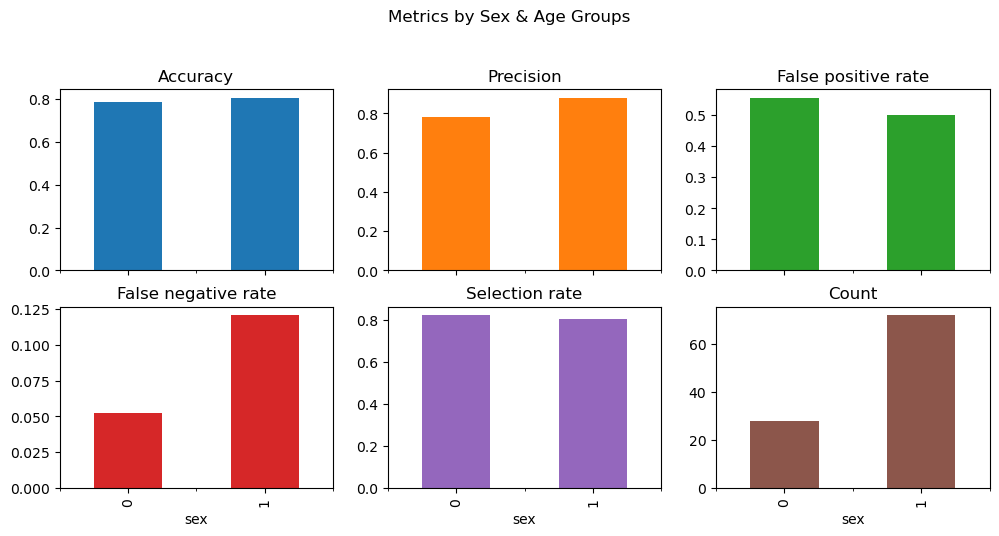

In [32]:
# Plot metrics using MetricFrame
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "False positive rate": false_positive_rate,
    "False negative rate": false_negative_rate,
    "Selection rate": selection_rate,
    "Count": count,
}

metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=preds, sensitive_features=A_test
)

# Plotting
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics by Sex & Age Groups",
)

In [33]:
# Some "difference" metrics (as in Nils' paper)
display(Markdown("#### Raw values")) 

# Accuracy difference
accuracy_values = metric_frame.by_group["Accuracy"]
acc_diff = accuracy_values.max() - accuracy_values.min()
print(f"Accuracy difference: {acc_diff:.4f}")

# Precision difference
precision_values = metric_frame.by_group["Precision"]
prec_diff = precision_values.max() - precision_values.min()
print(f"Precision difference: {prec_diff:.4f}")

# True positive rate (TPR) difference
# tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
tpr_values = 1 - metric_frame.by_group["False negative rate"]
tpr_diff = tpr_values.max() - tpr_values.min() 
print(f"True positive rate difference: {tpr_diff:.4f}")

# False positive rate (FPR) difference
# fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
fpr_values = metric_frame.by_group["False positive rate"]
fpr_diff = fpr_values.max() - fpr_values.min()
print(f"False positive rate difference: {fpr_diff:.4f}")

# Demographic parity (DemP) difference
dp_diff = demographic_parity_difference(y_true=y_test, y_pred=preds, sensitive_features=A_test)
print(f"Demographic parity difference: {dp_diff:.4f}")

# Equalized odds (EO) difference
# Defined as the greater of the 2 metrics: TPR difference and the FPR difference: max(tpr_diff, fpr_diff)
# Currently, this is the same as the TPR difference
eo_diff = equalized_odds_difference(y_true=y_test, y_pred=preds, sensitive_features=A_test)
print(f"Equalized odds difference: {eo_diff:.4f}")

#### Raw values

Accuracy difference: 0.0198
Precision difference: 0.0967
True positive rate difference: 0.0681
False positive rate difference: 0.0556
Demographic parity difference: 0.0159
Equalized odds difference: 0.0681
